<h3> Discretization theory to approximate and infinite square well with a linear term V(x) = alpha x </h3>

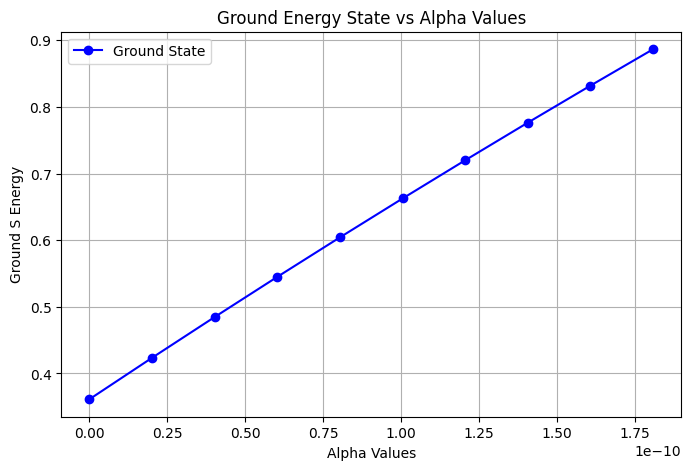

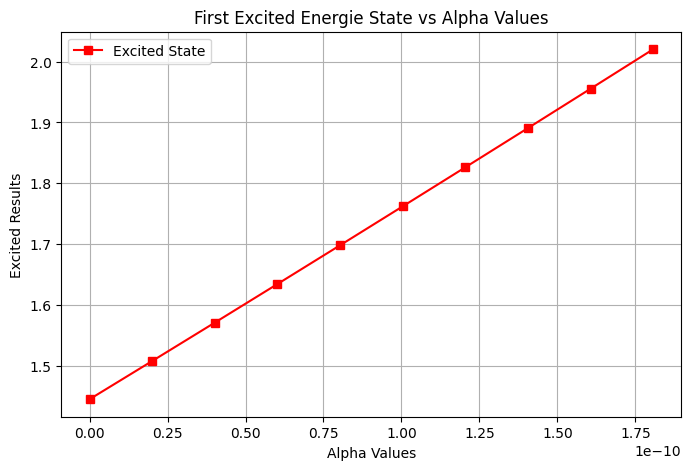

In [1]:
# For linear algebra calculations
import numpy as np
from numpy import linalg as LA

# For constants
import scipy as sci
from scipy import constants

# For plotting
import matplotlib.pyplot as plt

particle_mass = constants.electron_mass # using an electron
well_length = 1e-9

alpha_min = 0
delta_E2 = (3 * (np.pi**2) * (constants.hbar**2)) / (2 * particle_mass * (well_length**2))
alpha_max = delta_E2 / well_length
num_steps = 10
alpha_values = np.linspace(alpha_min, alpha_max, num_steps)

def discretization(L, Steps, m, alpha):
    # define the steo size
    a = L / Steps

    J = constants.hbar**2 / (2 * m * a**2)

    # introduce matrix
    #   ->  -J + 2 * J (diagonal index) - J
    Hamiltonian = [0] * (Steps+1)

    for i in range(Steps+1):
        row = [0] * (Steps+1)

        for j in range(Steps+1):
            if i == j:
                row[j] = 2 * J + V(i, a, alpha)
            if abs(j-i) == 1:
                row[j] = - J
        
        Hamiltonian[i] = row
        
    # calculate eigenvalues
    #   ->  calculate wave function psi_n at each discretization step
    eigenEnergies = LA.eig(Hamiltonian).eigenvalues

    return eigenEnergies

# potential for linear potential increase with linear term (alpha)
def V(n,a,alpha):
    return n * a * alpha

N = 100 # amount of discretized steps per wave-function

groundResults = [] # stores the ground state energies
excitedResults = [] # stores the first excited energies


for alpha in alpha_values:
    singleResult = sorted(discretization(well_length,N,particle_mass,alpha))

    groundResults.append(singleResult[0]/constants.electron_volt)
    excitedResults.append(singleResult[1]/constants.electron_volt)

groundResults = np.array(groundResults)
excitedResults = np.array(excitedResults)

plt.figure(figsize=(8, 5))
plt.plot(alpha_values, groundResults, label='Ground State', color='blue', marker='o')
plt.title('Ground Energy State vs Alpha Values')
plt.xlabel('Alpha Values')
plt.ylabel('Ground S Energy')
plt.grid(True)
plt.legend()

# 2. Create the second figure for Excited Results
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, excitedResults, label='Excited State', color='red', marker='s')
plt.title('First Excited Energie State vs Alpha Values')
plt.xlabel('Alpha Values')
plt.ylabel('Excited Results')
plt.grid(True)
plt.legend()

# Display both windows
plt.show()

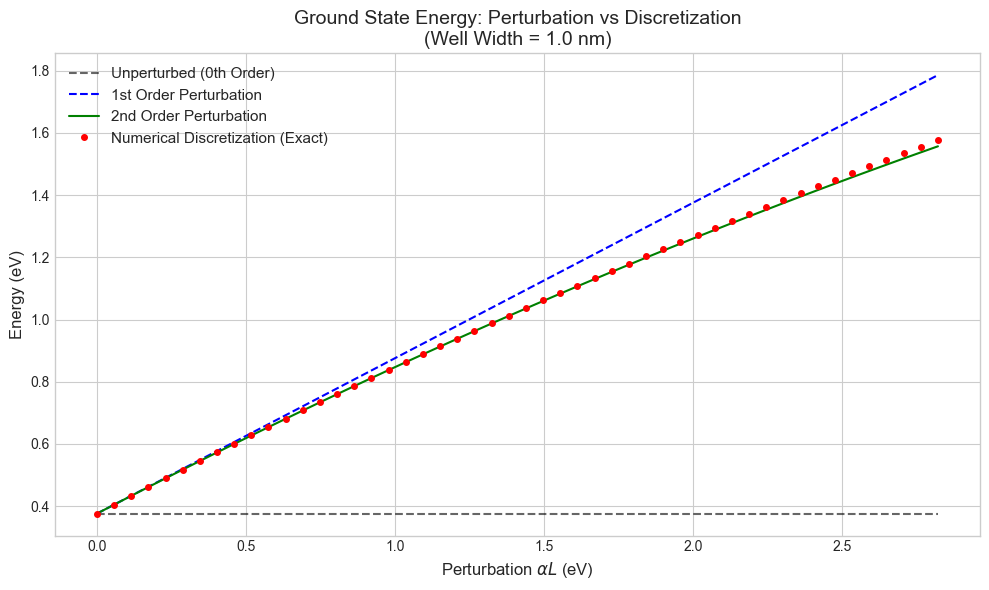

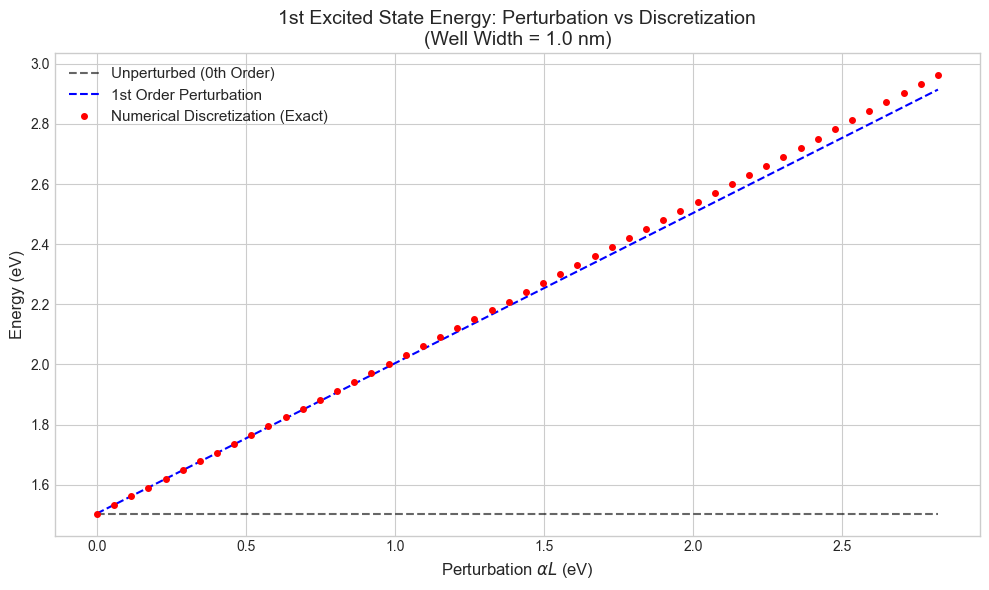

In [2]:
import math
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from numpy import linalg as LA

# ==========================================
# 1. PHYSICAL CONSTANTS & PARAMETERS
# ==========================================
particle_mass = sc.electron_mass 
well_length = 1e-9  # 1 nm

# Discretization settings
N_steps = 100       # Number of steps in the well (higher = more accurate)

# Alpha Range (Perturbation Strength)
# We go high enough to see where perturbation theory breaks down
alpha_min = 0
# Define max alpha based on energy spacing to ensure we see interesting physics
delta_E = (3 * (np.pi**2) * (sc.hbar**2)) / (2 * particle_mass * (well_length**2))
alpha_max = delta_E / well_length * 2.5 
num_alpha_steps = 50
alpha_values = np.linspace(alpha_min, alpha_max, num_alpha_steps)


# ==========================================
# 2. PERTURBATION THEORY FUNCTIONS
# ==========================================

def unperturbed_energy(n, mass, length):
    """ E_n = n^2 * pi^2 * hbar^2 / (2mL^2) """
    numerator = (n**2) * (np.pi**2) * (sc.hbar**2)
    denominator = 2 * mass * (length**2)
    return numerator / denominator

def first_order_correction(alpha, length):
    """ <n|V|n> = alpha * L / 2 """
    return (alpha * length) / 2

def second_order_correction_groundstate(alpha, mass, length, max_n=50):
    """ 
    Second order correction specifically for Ground State (n=1).
    Summing over even n states.
    """
    numerator = -128 * mass * (length**4) * (alpha**2)
    denominator = (np.pi**6) * (sc.hbar**2)
    prefactor = numerator / denominator

    sum_result = 0.0
    # Sum over even n (2, 4, 6...)
    for n in range(2, max_n + 1, 2):
        term = (n**2) / ((n**2 - 1)**5)
        sum_result += term
    
    return prefactor * sum_result


# ==========================================
# 3. NUMERICAL DISCRETIZATION FUNCTIONS
# ==========================================

def V_potential(index, step_size, alpha):
    """ The linear potential V(x) = alpha * x """
    x = index * step_size
    return alpha * x

def solve_discretization(L, Steps, m, alpha):
    """
    Constructs the Hamiltonian matrix using Finite Difference Method
    and returns sorted eigenvalues.
    """
    a = L / Steps # Step size
    t = sc.hbar**2 / (2 * m * a**2) # Kinetic hopping term

    # Initialize Hamiltonian as a zero matrix
    # Size is Steps-1 because boundary conditions are 0 at ends
    size = Steps - 1
    H = np.zeros((size, size))

    for i in range(size):
        # Diagonal elements: 2*t + V(x)
        H[i, i] = 2 * t + V_potential(i+1, a, alpha)
        
        # Off-diagonal elements: -t
        if i > 0:
            H[i, i-1] = -t
        if i < size - 1:
            H[i, i+1] = -t
            
    # Calculate eigenvalues (we only need eigenvalues, not vectors)
    eigenvalues = LA.eigvalsh(H) # eigvalsh is faster for symmetric matrices
    return np.sort(eigenvalues)


# ==========================================
# 4. CALCULATION LOOP
# ==========================================

# Lists to store results (in eV)
res_pert_0_ground = []
res_pert_1_ground = []
res_pert_2_ground = []
res_num_ground = []

res_pert_0_excited = []
res_pert_1_excited = []
res_num_excited = []

# Pre-calculate unperturbed energies
E0_ground_joules = unperturbed_energy(1, particle_mass, well_length)
E0_excited_joules = unperturbed_energy(2, particle_mass, well_length)

for alpha in alpha_values:
    # --- Perturbation Theory ---
    E1_corr = first_order_correction(alpha, well_length)
    E2_corr_ground = second_order_correction_groundstate(alpha, particle_mass, well_length)
    
    # Ground State Perturbation Results
    res_pert_0_ground.append(E0_ground_joules)
    res_pert_1_ground.append(E0_ground_joules + E1_corr)
    res_pert_2_ground.append(E0_ground_joules + E1_corr + E2_corr_ground)
    
    # Excited State Perturbation Results (Only 0th and 1st order calculated here)
    res_pert_0_excited.append(E0_excited_joules)
    res_pert_1_excited.append(E0_excited_joules + E1_corr)

    # --- Numerical Discretization ---
    eigenvalues = solve_discretization(well_length, N_steps, particle_mass, alpha)
    res_num_ground.append(eigenvalues[0])
    res_num_excited.append(eigenvalues[1])

# Convert lists to Numpy Arrays and scale to eV
to_eV = 1 / sc.electron_volt

# X-axis data: alpha in eV/nm
alpha_plot_units = alpha_values * well_length * to_eV

# Y-axis data: Ground State
y_pert0_g = np.array(res_pert_0_ground) * to_eV
y_pert1_g = np.array(res_pert_1_ground) * to_eV
y_pert2_g = np.array(res_pert_2_ground) * to_eV
y_num_g   = np.array(res_num_ground) * to_eV

# Y-axis data: Excited State
y_pert0_e = np.array(res_pert_0_excited) * to_eV
y_pert1_e = np.array(res_pert_1_excited) * to_eV

y_num_e   = np.array(res_num_excited) * to_eV


# ==========================================
# 5. PLOTTING
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid') # Optional: nice styling

# --- FIGURE 1: Ground State Comparison ---
plt.figure(figsize=(10, 6))
plt.title(f"Ground State Energy: Perturbation vs Discretization\n(Well Width = {well_length*1e9:.1f} nm)", fontsize=14)

plt.plot(alpha_plot_units, y_pert0_g, 'k--', label='Unperturbed (0th Order)', alpha=0.6)
plt.plot(alpha_plot_units, y_pert1_g, 'b--', label='1st Order Perturbation')
plt.plot(alpha_plot_units, y_pert2_g, 'g-',  label='2nd Order Perturbation')
plt.plot(alpha_plot_units, y_num_g,   'ro',  label='Numerical Discretization (Exact)', markersize=4)

plt.xlabel(r'Perturbation $\alpha L$ (eV)', fontsize=12)
plt.ylabel('Energy (eV)', fontsize=12)
plt.legend(fontsize=11)
plt.tight_layout()


# --- FIGURE 2: First Excited State Comparison ---
plt.figure(figsize=(10, 6))
plt.title(f"1st Excited State Energy: Perturbation vs Discretization\n(Well Width = {well_length*1e9:.1f} nm)", fontsize=14)

plt.plot(alpha_plot_units, y_pert0_e, 'k--', label='Unperturbed (0th Order)', alpha=0.6)
plt.plot(alpha_plot_units, y_pert1_e, 'b--', label='1st Order Perturbation')
plt.plot(alpha_plot_units, y_num_e,   'ro',  label='Numerical Discretization (Exact)', markersize=4)

plt.xlabel(r'Perturbation $\alpha L$ (eV)', fontsize=12)
plt.ylabel('Energy (eV)', fontsize=12)
plt.legend(fontsize=11)
plt.tight_layout()

plt.show()